In [1]:
%config Completer.use_jedi = False

In [2]:
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.statespace.varmax import VARMAX

import statsmodels.api as sm

import fbprophet
import prophet

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

### Load Data

In [4]:
perthTemp = pd.read_csv("data\\PerthTemperatures.csv")

### Check NULLs

In [5]:
perthTemp.isnull().sum()

Year                               1
Month                              1
Day                                1
Minimum temperature (Degree C)    76
Maximum temperature (Degree C)    31
Rainfall amount (millimetres)      0
Quality                           31
dtype: int64

### Handle NULLs

In [6]:
perthTemp.fillna(method='bfill', inplace=True)

In [7]:
perthTemp.isnull().sum()

Year                              1
Month                             1
Day                               1
Minimum temperature (Degree C)    0
Maximum temperature (Degree C)    1
Rainfall amount (millimetres)     0
Quality                           1
dtype: int64

In [8]:
perthTemp.drop(perthTemp.tail(1).index[0], inplace=True)

In [9]:
perthTemp.isnull().sum()

Year                              0
Month                             0
Day                               0
Minimum temperature (Degree C)    0
Maximum temperature (Degree C)    0
Rainfall amount (millimetres)     0
Quality                           0
dtype: int64

### Handle dates

In [10]:
perthTemp.drop(columns=['Quality'], inplace=True)
perthTemp

,Year,Month,Day,Minimum temperature (Degree C),Maximum temperature (Degree C),Rainfall amount (millimetres)
0,1944.0,6.0,3.0,11.0,22.3,0.0
1,1944.0,6.0,4.0,12.2,23.4,0.0
2,1944.0,6.0,5.0,12.0,20.3,2.0
3,1944.0,6.0,6.0,7.4,18.7,3.3
4,1944.0,6.0,7.0,5.9,21.3,0.3
...,...,...,...,...,...,...
27641,2020.0,2.0,6.0,21.0,32.6,0.0
27642,2020.0,2.0,7.0,20.7,30.6,0.0
27643,2020.0,2.0,8.0,19.6,28.2,0.0
27644,2020.0,2.0,9.0,14.1,29.8,0.0


In [11]:
perthTemp = perthTemp.astype({'Year': int, 'Month': int, 'Day': int})
perthTemp = perthTemp.astype({'Year': str, 'Month': str, 'Day': str})

In [12]:
perthTemp['Date'] = perthTemp[['Year','Month','Day']].agg('-'.join, axis = 1)

In [13]:
perthTemp.drop(columns=['Year', 'Month', 'Day'], inplace=True)

In [14]:
perthTemp['Date'] = pd.to_datetime(perthTemp['Date'])

In [15]:
perthTemp.dtypes

Minimum temperature (Degree C)           float64
Maximum temperature (Degree C)           float64
Rainfall amount (millimetres)            float64
Date                              datetime64[ns]
dtype: object

### Set date as index

In [17]:
perthTemp = perthTemp.set_index('Date')

### Train Test Split

In [18]:
perthTemp_Train = perthTemp[:'2010-12-31']

perthTemp_Test = perthTemp['2011-01-01':]

In [19]:
perthTempMS = perthTemp.resample('MS').mean()

In [20]:
perthTempMS_Train = perthTempMS[:799]

perthTempMS_Test = perthTempMS[799:]

### Datasets

In [23]:
perthTempMS_Train.tail(50)

,Minimum temperature (Degree C),Maximum temperature (Degree C),Rainfall amount (millimetres)
Date,,,
2006-11-01,14.633333,28.143333,0.640000
2006-12-01,15.703226,31.529032,0.122581
2007-01-01,15.209677,30.396774,0.651613
2007-02-01,16.425000,31.435714,0.100000
2007-03-01,15.458065,30.912903,0.174194
2007-04-01,11.256667,25.693333,2.353333
2007-05-01,10.070968,21.241935,2.212903
2007-06-01,9.000000,19.860000,1.780000
2007-07-01,10.122581,19.661290,6.238710


In [22]:
perthTempMS_Test.head(50)

,Minimum temperature (Degree C),Maximum temperature (Degree C),Rainfall amount (millimetres)
Date,,,
2011-01-01,18.967742,33.700000,1.393548
2011-02-01,20.817857,34.914286,0.014286
2011-03-01,18.490323,32.754839,0.000000
2011-04-01,14.203333,27.936667,0.873333
2011-05-01,10.958065,23.587097,1.890323
2011-06-01,9.950000,19.676667,4.773333
2011-07-01,8.554839,18.387097,5.309677
2011-08-01,8.819355,20.154839,4.122581
2011-09-01,8.903333,20.483333,3.413333


### Visualize

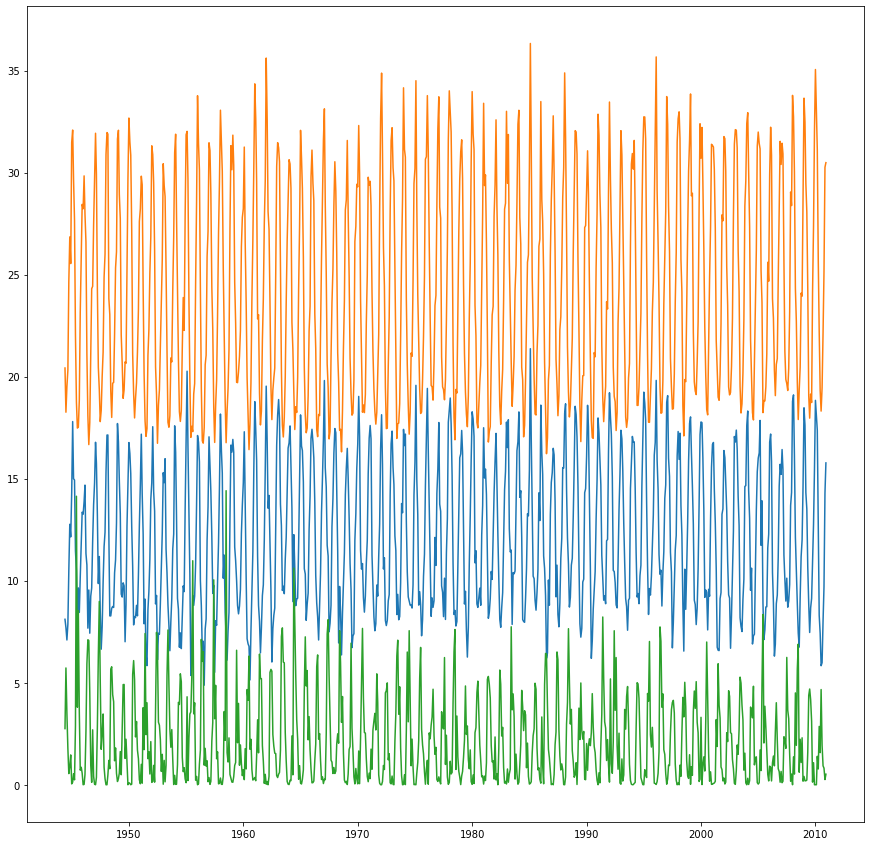

In [28]:
plt.figure(figsize=(15,15))
plt.plot(perthTempMS_Train)
plt.show()

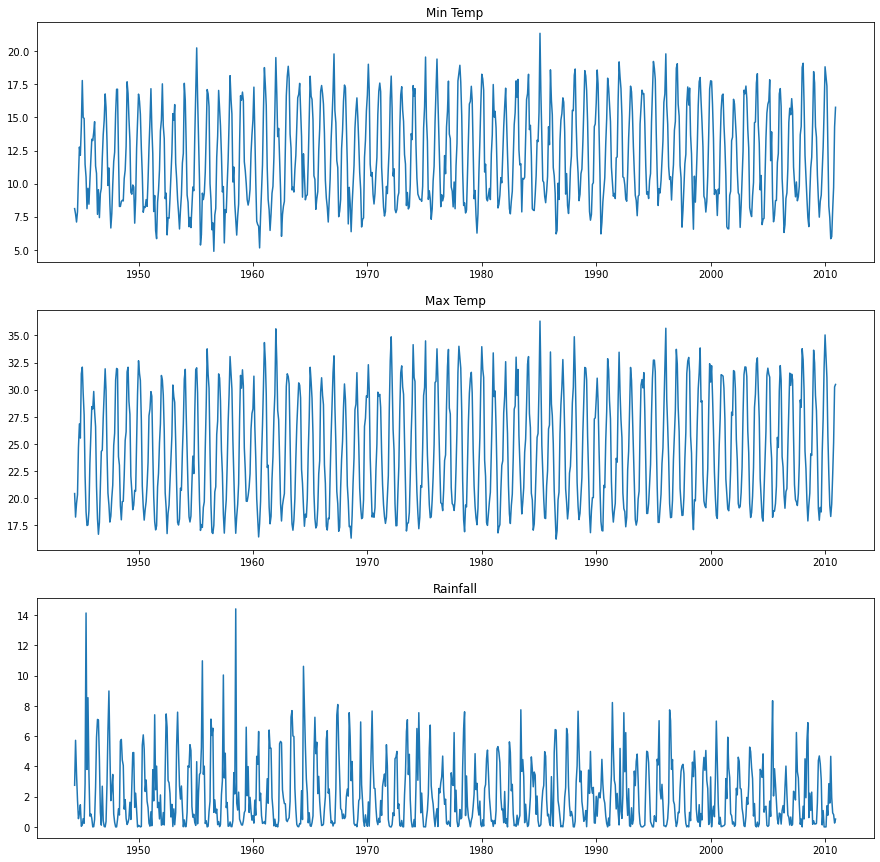

In [26]:
plt.figure(figsize=(15,15))

plt.subplot(3, 1, 1)
plt.title('Min Temp')
plt.plot(perthTempMS_Train['Minimum temperature (Degree C)'])

plt.subplot(3, 1, 2)
plt.title('Max Temp')
plt.plot(perthTempMS_Train['Maximum temperature (Degree C)'])

plt.subplot(3, 1, 3)
plt.title('Rainfall')
plt.plot(perthTempMS_Train['Rainfall amount (millimetres)'])


plt.show()

### Forecasting with Prophet

In [34]:
perthMinTemp = perthTempMS_Train[['Minimum temperature (Degree C)']].reset_index().rename(columns={'Date':'ds',
                                                                                    'Minimum temperature (Degree C)':'y'})

In [35]:
perthMaxTemp = perthTempMS_Train[['Maximum temperature (Degree C)']].reset_index().rename(columns={'Date':'ds',
                                                                                    'Maximum temperature (Degree C)':'y'})

In [36]:
perthRainfall = perthTempMS_Train[['Rainfall amount (millimetres)']].reset_index().rename(columns={'Date':'ds',
                                                                                    'Rainfall amount (millimetres)':'y'})

### Model

In [39]:
prophet_perthMinTemp = fbprophet.Prophet()
prophet_perthMaxTemp = fbprophet.Prophet()
prophet_perthRainfall = fbprophet.Prophet()

In [40]:
prophet_perthMinTemp.fit(perthMinTemp)
prophet_perthMaxTemp.fit(perthMaxTemp)
prophet_perthRainfall.fit(perthRainfall)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### Forecast Dates

In [51]:
forecastDates = pd.DataFrame(perthTempMS_Test.index).rename(columns={'Date':'ds'})

### Forecast

In [53]:
forecast_minTemp = prophet_perthMinTemp.predict(forecastDates)
forecast_maxTemp = prophet_perthMaxTemp.predict(forecastDates)
forecast_rainfall = prophet_perthRainfall.predict(forecastDates)

In [55]:
forecast_minTemp_1 = forecast_minTemp[['ds', 'yhat']]
forecast_maxTemp_1 = forecast_maxTemp[['ds', 'yhat']]
forecast_rainfall_1 = forecast_rainfall[['ds', 'yhat']]

In [65]:
minTemp_Values = pd.concat([perthTempMS_Test[['Minimum temperature (Degree C)']],
           forecast_minTemp_1.set_index('ds')], axis = 1).rename(columns = {'Minimum temperature (Degree C)':'actual'})

In [66]:
maxTemp_Values = pd.concat([perthTempMS_Test[['Maximum temperature (Degree C)']],
           forecast_maxTemp_1.set_index('ds')], axis = 1).rename(columns = {'Maximum temperature (Degree C)':'actual'})

In [67]:
rainfall_Values = pd.concat([perthTempMS_Test[['Rainfall amount (millimetres)']],
           forecast_rainfall_1.set_index('ds')], axis = 1).rename(columns = {'Rainfall amount (millimetres)':'actual'})

### Plot

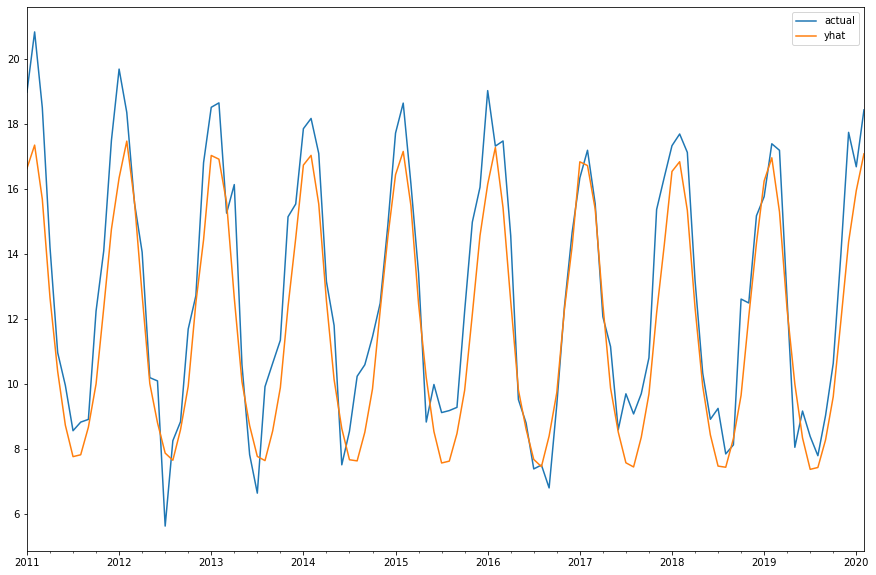

In [77]:
minTemp_Values.plot(figsize=(15,10))

plt.show()

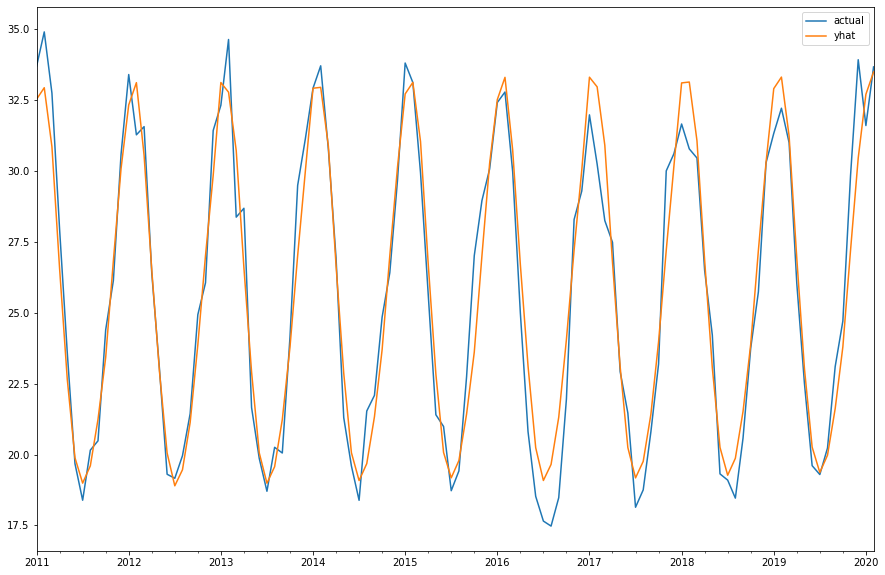

In [78]:
maxTemp_Values.plot(figsize=(15,10))

plt.show()

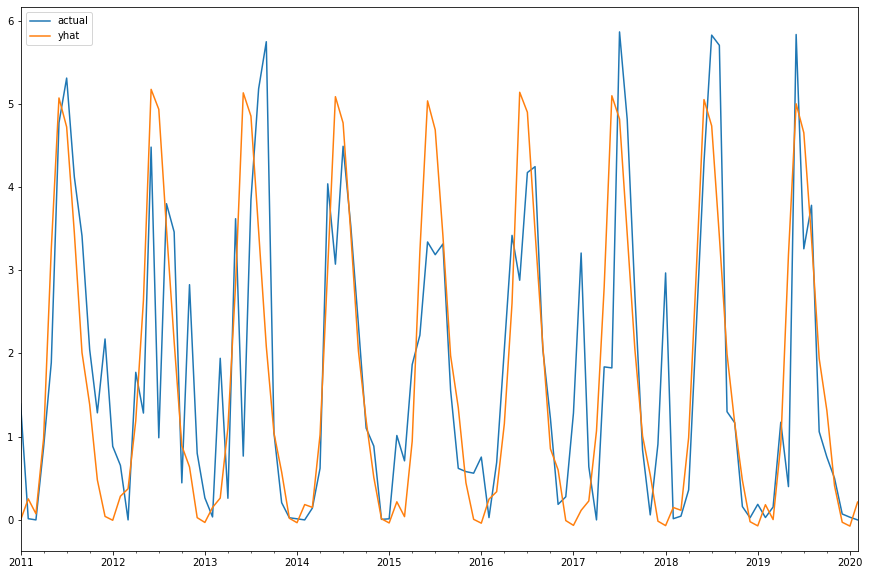

In [79]:
rainfall_Values.plot(figsize=(15,10))

plt.show()

### Evaluate

In [80]:
mae = mean_absolute_error(minTemp_Values['actual'], minTemp_Values['yhat'])
print('MAE: %.3f' % mae)

mape = mean_absolute_percentage_error(minTemp_Values['actual'], minTemp_Values['yhat'])
print('MAPE: %.3f' % mape)

MAE: 1.274
MAPE: 0.103


In [81]:
mae = mean_absolute_error(maxTemp_Values['actual'], maxTemp_Values['yhat'])
print('MAE: %.3f' % mae)

mape = mean_absolute_percentage_error(maxTemp_Values['actual'], maxTemp_Values['yhat'])
print('MAPE: %.3f' % mape)

MAE: 1.064
MAPE: 0.042


In [82]:
mae = mean_absolute_error(rainfall_Values['actual'], rainfall_Values['yhat'])
print('MAE: %.3f' % mae)

mape = mean_absolute_percentage_error(rainfall_Values['actual'], rainfall_Values['yhat'])
print('MAPE: %.3f' % mape)

MAE: 0.835
MAPE: 78458750515127.125
